In [6]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [7]:
 # Load csv file of bitcoin data
csv_path = Path("ETH_USD_2015TillNow.csv")
eth=pd.read_csv(csv_path)
eth.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,ETH,2015-08-08,0.909046,1.749289,1.916540,0.794497
1,ETH,2015-08-09,0.692321,0.909046,0.909046,0.692321
2,ETH,2015-08-10,0.668067,0.692321,0.692321,0.654331
3,ETH,2015-08-11,0.850151,0.668067,1.148621,0.668067
4,ETH,2015-08-12,1.266023,0.850151,1.266023,0.850151


In [8]:
eth = eth.drop(columns="Currency")

In [9]:
eth['Date']=eth['Date'].astype('datetime64[ns]')

In [10]:
# Set the `Date` column as the index
eth = eth.set_index("Date", drop=True)

In [11]:
eth.head()

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,
2015-08-08,0.909046,1.749289,1.916540,0.794497
2015-08-09,0.692321,0.909046,0.909046,0.692321
2015-08-10,0.668067,0.692321,0.692321,0.654331
2015-08-11,0.850151,0.668067,1.148621,0.668067
2015-08-12,1.266023,0.850151,1.266023,0.850151


In [12]:
# Rename the columns
eth.columns = ['Close', 'Open', 'High', 'Low']
eth.head()

,Close,Open,High,Low
Date,,,,
2015-08-08,0.909046,1.749289,1.916540,0.794497
2015-08-09,0.692321,0.909046,0.909046,0.692321
2015-08-10,0.668067,0.692321,0.692321,0.654331
2015-08-11,0.850151,0.668067,1.148621,0.668067
2015-08-12,1.266023,0.850151,1.266023,0.850151


In [13]:
## Initialize the short and long windows
short_window = 4
long_window = 100

In [14]:
## Initialize the signals DataFrame with the signal column

signals = pd.DataFrame(index=eth.index)
signals['close'] = eth['Close']
signals['signal'] = 0.0

In [15]:
## Create short simple moving average over the short window

signals['SMA4'] = eth['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

In [16]:
## Create long simple moving average over the long window

signals['SMA100'] = eth['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

In [17]:
## Create signals

signals['signal'][short_window:] = np.where(signals['SMA4'][short_window:] > signals['SMA100'][short_window:],1.0,0.0)

In [18]:
## Generate trading orders

signals['entry/exit'] = signals['signal'].diff()

In [19]:
signals.head()

,close,signal,SMA4,SMA100,entry/exit
Date,,,,,
2015-08-08,0.909046,0.0,0.909046,0.909046,NaN
2015-08-09,0.692321,0.0,0.800683,0.800683,0.0
2015-08-10,0.668067,0.0,0.756478,0.756478,0.0
2015-08-11,0.850151,0.0,0.779896,0.779896,0.0
2015-08-12,1.266023,0.0,0.869140,0.877122,0.0


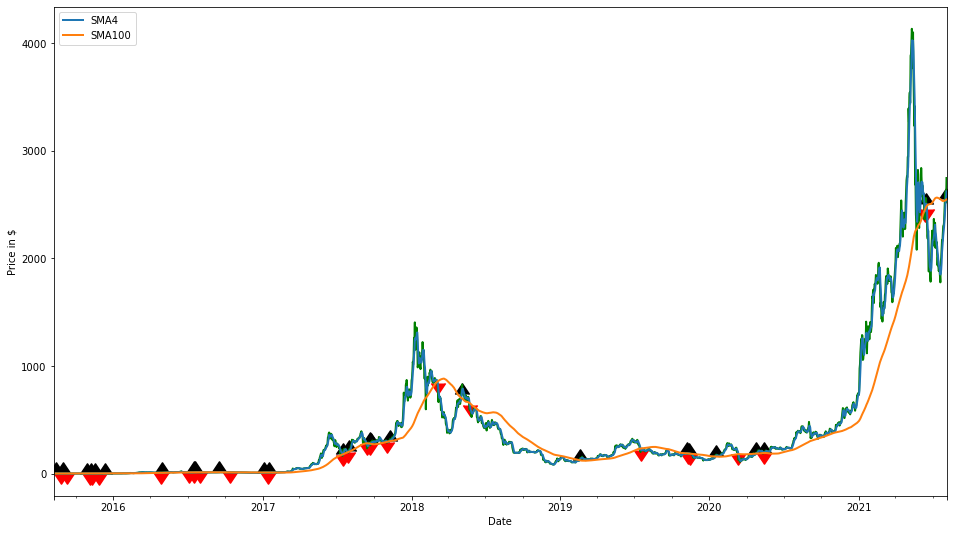

In [20]:
## Initialize the plot figure

fig = plt.figure(figsize=(16,9))

## Add a subplot and label for y-axis

ax1 = fig.add_subplot(111,ylabel='Price in $')

## Plot the closing price

eth['Close'].plot(ax=ax1, color='g', lw=2.)

## Plot the short and long moving averages

signals[['SMA4','SMA100']].plot(ax=ax1, lw=2.)

## Plot the buy signals

#signals.short_mavg[signals.positions == 1.0].scatter(ax=ax1, color='g')
plt.scatter(signals.loc[signals['entry/exit'] == 1.0].index, 
            signals.SMA4[signals['entry/exit'] == 1.0],
            marker=10, s=200, color='black')

## Plot the sell signals
plt.scatter(signals.loc[signals['entry/exit'] == -1.0].index,
            signals.SMA4[signals['entry/exit'] == -1.0],
            marker=11, s=200, color='r')


## Show the plot

plt.show()

### Backtest the Trading Strategy

In [21]:
# Set initial capital
initial_capital = float(100000)

# Set the share size
share_size = 500

# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
signals['Position'] = share_size * signals['signal']

# Find the points in time where a 500 share position is bought or sold
signals['Entry/Exit Position'] = signals['Position'].diff()

# Multiply share price by entry/exit positions and get the cumulatively sum
signals['Portfolio Holdings'] = signals['close'] * signals['Entry/Exit Position'].cumsum()

# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
signals['Portfolio Cash'] = initial_capital - (signals['close'] * signals['Entry/Exit Position']).cumsum()

# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
signals['PortfolioTotal'] = signals['Portfolio Cash'] + signals['Portfolio Holdings']

# Calculate the portfolio daily returns
signals['Portfolio Daily Returns'] = signals['PortfolioTotal'].pct_change()

# Calculate the cumulative returns
signals['Portfolio Cumulative Returns'] = (1 + signals['Portfolio Daily Returns']).cumprod() - 1

# Print the DataFrame
signals.tail()

,close,signal,SMA4,SMA100,entry/exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,PortfolioTotal,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,
2021-07-31,2536.697075,0.0,2401.935741,2536.194380,0.0,0.0,0.0,0.000000e+00,1.390937e+06,1.390937e+06,0.000000,12.909372
2021-08-01,2599.328148,0.0,2475.923295,2538.897346,0.0,0.0,0.0,0.000000e+00,1.390937e+06,1.390937e+06,0.000000,12.909372
2021-08-02,2623.907049,1.0,2548.857738,2542.422636,1.0,500.0,500.0,1.311954e+06,7.898373e+04,1.390937e+06,0.000000,12.909372
2021-08-03,2518.491323,1.0,2569.605899,2544.845269,0.0,500.0,0.0,1.259246e+06,7.898373e+04,1.338229e+06,-0.037894,12.382294
2021-08-04,2746.474842,1.0,2622.050340,2547.156922,0.0,500.0,0.0,1.373237e+06,7.898373e+04,1.452221e+06,0.085181,13.522211


### Plot Entry/Exit Points of Trading Strategy vs. Backtest Results

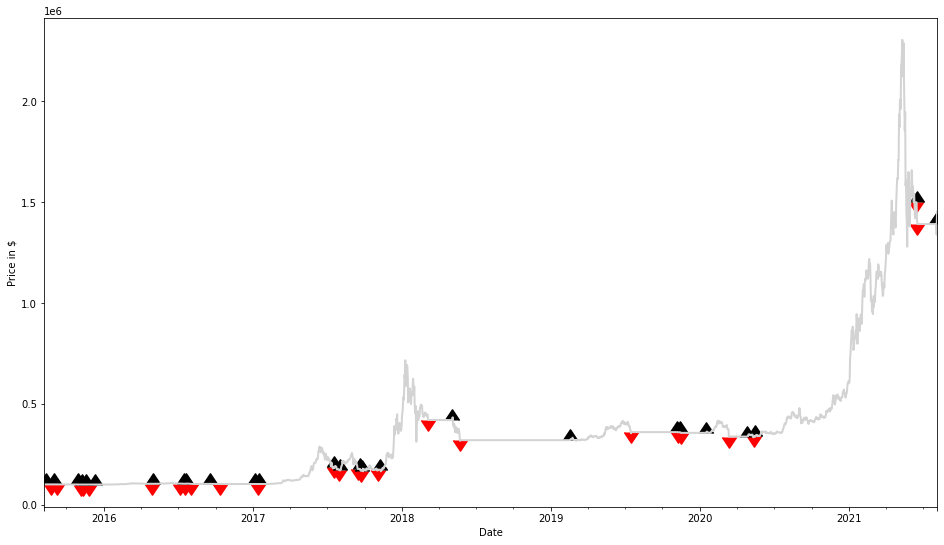

In [22]:
# Visualize exit position relative to total portfolio value
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111,ylabel='Price in $')

## Plot the total portoflio value for the investment
signals['PortfolioTotal'].plot(ax=ax1, color='lightgrey', lw=2.)

# Plot exit position relative to total portfolio value
plt.scatter(signals.loc[signals['entry/exit'] == -1.0].index,
            signals.PortfolioTotal[signals['entry/exit'] == -1.0],
            marker=11, s=200, color='r')

# Plot entry position relative to total portfolio value
plt.scatter(signals.loc[signals['entry/exit'] == 1.0].index,
            signals.PortfolioTotal[signals['entry/exit'] == 1.0],
            marker=10, s=200, color='black')

In [23]:
signals[signals['entry/exit'] == 1.0]['PortfolioTotal']

Date
2015-08-13    1.000000e+05
2015-09-01    9.955156e+04
2015-10-29    9.949487e+04
2015-11-08    9.932620e+04
2015-11-18    9.917826e+04
2015-12-11    9.913020e+04
2016-04-30    1.023826e+05
2016-07-16    1.032036e+05
2016-07-20    1.029927e+05
2016-09-17    1.021279e+05
2017-01-05    1.016310e+05
2017-01-16    1.015040e+05
2017-07-18    1.869244e+05
2017-08-01    1.723704e+05
2017-09-20    1.765019e+05
2017-09-24    1.673634e+05
2017-11-09    1.728664e+05
2018-05-04    4.193264e+05
2019-02-17    3.191972e+05
2019-11-07    3.592647e+05
2019-11-12    3.583230e+05
2020-01-16    3.555229e+05
2020-04-25    3.372008e+05
2020-05-14    3.401287e+05
2021-06-15    1.498432e+06
2021-08-02    1.390937e+06
Name: PortfolioTotal, dtype: float64

### portofolio evaluation metrics

In [24]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

,Backtest
Annual Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [25]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = signals['Portfolio Cumulative Returns'][-1]

# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = (
    signals['Portfolio Daily Returns'].mean() * 252
)

# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = (
    signals['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    signals['Portfolio Daily Returns'].mean() * 252) / (
    signals['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Downside Return
sortino_ratio_df = signals[['Portfolio Daily Returns']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0

target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
portfolio_evaluation_df

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
portfolio_evaluation_df.head()

,Backtest
Annual Return,0.402131
Cumulative Returns,13.522211
Annual Volatility,0.43191
Sharpe Ratio,0.931053
Sortino Ratio,1.409393


### Trade Evaluation Metrics

In [26]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        'Cryptocurrency', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

trade_evaluation_df

,Cryptocurrency,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss


In [27]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in signals.iterrows():
    if row['entry/exit'] == 1:
        entry_date = index
        entry_portfolio_holding = abs(row['Portfolio Holdings'])
        share_size = row['Entry/Exit Position']
        entry_share_price = row['close']

    elif row['entry/exit'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['close'] * row['Entry/Exit Position'])
        exit_share_price = row['close']
        profit_loss =  exit_portfolio_holding - entry_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Cryptocurrency': 'ETH',
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df

,Cryptocurrency,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,ETH,2015-08-13,2015-08-25,500.0,1.951460,1.054577,9.757300e+02,5.272885e+02,-4.484415e+02
1,ETH,2015-09-01,2015-09-09,500.0,1.327498,1.214120,6.637490e+02,6.070600e+02,-5.668900e+01
2,ETH,2015-10-29,2015-11-06,500.0,1.254080,0.916739,6.270400e+02,4.583695e+02,-1.686705e+02
3,ETH,2015-11-08,2015-11-11,500.0,1.080845,0.784963,5.404225e+02,3.924815e+02,-1.479410e+02
4,ETH,2015-11-18,2015-11-26,500.0,0.991469,0.895359,4.957345e+02,4.476795e+02,-4.805500e+01
5,ETH,2015-12-11,2016-04-28,500.0,0.957485,7.462268,4.787425e+02,3.731134e+03,3.252392e+03
6,ETH,2016-04-30,2016-07-05,500.0,8.684684,10.326753,4.342342e+03,5.163377e+03,8.210345e+02
7,ETH,2016-07-16,2016-07-18,500.0,11.561825,11.139944,5.780913e+03,5.569972e+03,-2.109405e+02
8,ETH,2016-07-20,2016-08-01,500.0,12.376475,10.646814,6.188237e+03,5.323407e+03,-8.648305e+02
9,ETH,2016-09-17,2016-10-12,500.0,12.739668,11.746050,6.369834e+03,5.873025e+03,-4.968090e+02
